<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/031_PyTorch_Proj_ThirtyOne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# util
import os, sys, random
import numpy as np
from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image
from pathlib import Path
# google
from google.colab import drive
# torch
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.utils as vutils
from torch import distributions
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
# sklearn
from sklearn import datasets
# vis
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from pylab import rcParams

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


In [ ]:
rcParams['figure.figsize'] = 5, 4
rcParams['figure.dpi'] = 150

In [ ]:
%matplotlib inline

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive



## U-Net Image Segmentation

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/DataSets/"
data_path = os.path.join(ROOT_DIR,'carvana/')

In [ ]:
# with ZipFile(data_path+'train.zip', 'r') as zf:
#    zf.extractall(data_path+'carvana-image-masking-challenge/working')

In [ ]:
# with ZipFile(data_path+'train_masks.zip', 'r') as zf:
#    zf.extractall(data_path+'carvana-image-masking-challenge/working')

In [ ]:
class DataSet(Dataset):
    def __init__(self, root_dir: str, train=True, transforms=None):
        super(DataSet, self).__init__()
        self.train = train
        self.transforms = transforms

        file_path = root_dir + 'train/*.*'
        file_mask_path = root_dir + 'train_masks/*.*'

        self.images = sorted(glob(file_path))
        self.image_mask = sorted(glob(file_mask_path))

        split_ratio = int(len(self.images) * 0.7)
        if train:
            self.images = self.images[:split_ratio]
            self.image_mask = self.image_mask[:split_ratio]
        else:
            self.images = self.images[split_ratio:]
            self.image_mask = self.image_mask[split_ratio:]

    def __getitem__(self, index: int):
        image = Image.open(self.images[index]).convert('RGB')
        image_mask = Image.open(self.image_mask[index]).convert('L')

        if self.transforms:
            image = self.transforms(image)
            image_mask = self.transforms(image_mask)

        return {'img': image, 'mask': image_mask}

    def __len__(self):
        return len(self.images)

In [ ]:
batch_size = 16
n_workers = 2
width = 256
height = 256
channels = 3

In [ ]:
seed = 44
random.seed(seed)
torch.manual_seed(seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device, device.type, type(device)

(device(type='cpu'), 'cpu', torch.device)

In [ ]:
transforms = T.Compose([T.Resize((width, height)), T.ToTensor()])
transforms, type(transforms)

(Compose(
     Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ),
 torchvision.transforms.transforms.Compose)

In [ ]:
train_dataset = DataSet(root_dir=data_path+'carvana-image-masking-challenge/working/',
                                 train=True,
                                 transforms=transforms)
val_dataset = DataSet(root_dir=data_path+'carvana-image-masking-challenge/working/',
                                train=False,
                                transforms=transforms)
train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=n_workers)
val_dataset_loader = DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=n_workers)

In [ ]:
train_dataset.__getitem__(0), train_dataset.__len__(), type(train_dataset)

({'img': tensor([[[0.9569, 0.9490, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
           [0.9529, 0.9490, 0.9569,  ..., 0.9569, 0.9529, 0.9569],
           [0.9490, 0.9490, 0.9569,  ..., 0.9569, 0.9490, 0.9529],
           ...,
           [0.7020, 0.6980, 0.6980,  ..., 0.6902, 0.6902, 0.6902],
           [0.7020, 0.6980, 0.6980,  ..., 0.6863, 0.6863, 0.6863],
           [0.7020, 0.6980, 0.6941,  ..., 0.6824, 0.6824, 0.6863]],
  
          [[0.9608, 0.9529, 0.9569,  ..., 0.9569, 0.9569, 0.9569],
           [0.9569, 0.9529, 0.9569,  ..., 0.9569, 0.9529, 0.9569],
           [0.9529, 0.9529, 0.9569,  ..., 0.9569, 0.9490, 0.9529],
           ...,
           [0.7176, 0.7137, 0.7137,  ..., 0.7059, 0.7059, 0.7059],
           [0.7176, 0.7137, 0.7137,  ..., 0.7020, 0.7020, 0.7020],
           [0.7176, 0.7137, 0.7098,  ..., 0.6980, 0.6980, 0.7020]],
  
          [[0.9412, 0.9373, 0.9529,  ..., 0.9569, 0.9569, 0.9569],
           [0.9373, 0.9373, 0.9529,  ..., 0.9569, 0.9529, 0.9569],
           [0.9

In [ ]:
train_dataset_loader, type(train_dataset_loader)

(<torch.utils.data.dataloader.DataLoader at 0x7d7457c77280>,
 torch.utils.data.dataloader.DataLoader)

In [ ]:
samples = next(iter(train_dataset_loader))

In [ ]:
type(samples), samples['img'].shape

(dict, torch.Size([16, 3, 256, 256]))

In [ ]:
vutils.make_grid(samples['img'], padding=10).numpy().shape

(3, 542, 2138)

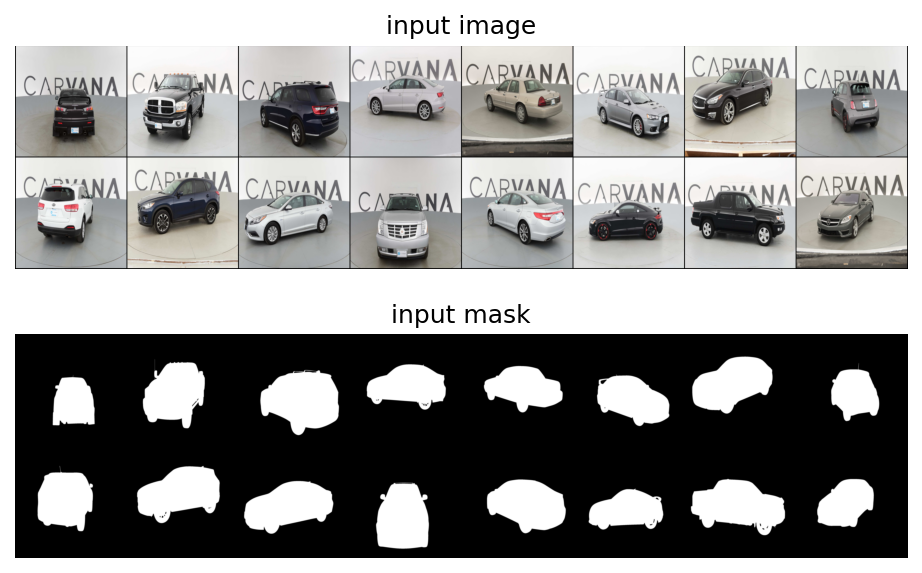

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))
fig.tight_layout()
ax1.axis('off')
ax1.set_title('input image')
ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(), (1, 2, 0)))
ax2.axis('off')
ax2.set_title('input mask')
ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(), (1, 2, 0)), cmap='gray')
plt.show()

In [ ]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

    def forward(self, x1, x2): # x1 (bs, out_ch, w1, h1) x2 (bs, in_ch, w2, h2)
        x2 = self.up_scale(x2) # (bs, out_ch, 2*w2, 2*h2)
        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2]) # (bs, out_ch, w1, h1)
        x = torch.cat([x2, x1], dim=1) # (bs, 2*out_ch, w1, h1)
        return x

class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch): # 2*out_ch = in_ch
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2): # x1 (bs, out_ch, w1, h1) x2 (bs, in_ch, w2, h2)
        a = self.up(x1, x2) # (bs, 2*out_ch, w1, h1)
        x = self.conv(a) # (bs, out_ch, w1, h1) since 2*out_ch = in_ch
        return x

In [ ]:
# simple test
in_ch = 8
out_ch = 4
x_1 = torch.randn(batch_size, out_ch, 256, 256)
x_2 = torch.randn(batch_size, in_ch, 127, 125)
up_test = up(in_ch, out_ch)
y = up_test(x_1, x_2)
print(y.shape)
up_test = up_layer(in_ch,out_ch)
y = up_test(x_1,x_2)
print(y.shape)

torch.Size([16, 8, 256, 256])
torch.Size([16, 4, 256, 256])


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.conv1 = double_conv(in_channels, 64)
        self.down1 = down_layer(64, 128)
        self.down2 = down_layer(128, 256)
        self.down3 = down_layer(256, 512)
        self.down4 = down_layer(512, 1024)
        self.up1 = up_layer(1024, 512)
        self.up2 = up_layer(512, 256)
        self.up3 = up_layer(256, 128)
        self.up4 = up_layer(128, 64)
        self.last_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x): # (bs,in_channels, w, d)
        x1 = self.conv1(x) # (bs, 64, w, d)
        x2 = self.down1(x1) # (bs, 128, w/2, d/2)
        x3 = self.down2(x2) # (bs, 256, w/4, d/4)
        x4 = self.down3(x3) # (bs, 512, w/8, h/8)
        x5 = self.down4(x4) # (bs, 1024, w/16, h/16)
        x1_up = self.up1(x4, x5) # (bs, 512, w/8, h/8)
        x2_up = self.up2(x3, x1_up) # (bs, 256, w/4, h/4)
        x3_up = self.up3(x2, x2_up) # (bs, 128, w/2, h/2)
        x4_up = self.up4(x1, x3_up) # (bs, 64, w, h)
        output = self.last_conv(x4_up) # (bs, out_channels, w, h)
        return output

In [ ]:
model = UNet(in_channels=3, out_channels=1)
model

UNet(
  (conv1): double_conv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): down_layer(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
x = torch.randn(batch_size, 3, 256, 128)
y = model(x)
y.shape

torch.Size([16, 1, 256, 128])

In [ ]:
def dice_score(pred: torch.Tensor, mask: torch.Tensor):
    dice = (2 * (pred * mask).sum()) / (pred + mask).sum()
    return np.mean(dice.cpu().numpy())

def pixel_accuracy(pred: torch.Tensor, val_mask: torch.Tensor):
    correct = torch.eq(pred, val_mask).int()
    return float(correct.sum()) / float(correct.numel())

In [ ]:
def plot_pred_img(samples, pred):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
    fig.tight_layout()

    ax1.axis('off')
    ax1.set_title('input image')
    ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(), (1, 2, 0)))

    ax2.axis('off')
    ax2.set_title('input mask')
    ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(), (1, 2, 0)), cmap='gray')

    ax3.axis('off')
    ax3.set_title('predicted mask')
    ax3.imshow(np.transpose(vutils.make_grid(pred, padding=2).cpu().numpy(), (1, 2, 0)), cmap='gray')

    plt.show()

def plot_train_progress(model):
    samples = next(iter(val_dataset_loader))
    val_img = samples['img'].to(device)
    val_mask = samples['mask'].to(device)
    pred = model(val_img)
    plot_pred_img(samples, pred.detach())

In [ ]:
def train(model, optimizer, criteration, scheduler=None):
    train_losses = []
    val_lossess = []
    lr_rates = []
    # epochs = int(n_iters / (len(train_dataset) / batch_size))
    for epoch in range(epochs):
        model.train()
        train_total_loss = 0
        train_iterations = 0

        for idx, data in enumerate(tqdm(train_dataset_loader)):
            train_iterations += 1
            train_img = data['img'].to(device)
            train_mask = data['mask'].to(device)

            optimizer.zero_grad()
            with torch.autocast(device_type='cuda'):
                train_output_mask = model(train_img)
                train_loss = criterion(train_output_mask, train_mask)
                train_total_loss += train_loss.item()

            train_loss.backward()
            optimizer.step()

        train_epoch_loss = train_total_loss / train_iterations
        train_losses.append(train_epoch_loss)

        # evaluate mode
        model.eval()
        with torch.no_grad():
            val_total_loss = 0
            val_iterations = 0
            scores = 0

            for vidx, val_data in enumerate(tqdm(val_dataset_loader)):
                val_iterations += 1
                val_img = val_data['img'].to(device)
                val_mask = val_data['mask'].to(device)

                with torch.autocast(device_type='cuda'):
                    pred = model(val_img)
                    val_loss = criterion(pred, val_mask)
                    val_total_loss += val_loss.item()
                    scores += dice_score(pred, val_mask)

            val_epoch_loss = val_total_loss / val_iterations
            dice_coef_scroe = scores / val_iterations
            val_lossess.append(val_epoch_loss)
            plot_train_progress(model)
            print('epochs - {}/{} [{}/{}], dice score: {}, train loss: {}, val loss: {}'.format(
                epoch+1, epochs,
                idx+1, len(train_dataset_loader),
                dice_coef_scroe, train_epoch_loss, val_epoch_loss
            ))

        lr_rates.append(optimizer.param_groups[0]['lr'])
        if scheduler:
            scheduler.step(val_epoch_loss)

    return {
        'lr': lr_rates,
        'train_loss': train_losses,
        'valid_loss': val_lossess
    }

In [ ]:
epochs = 2
learning_rate = 0.0001
model = UNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)
history = train(model, optimizer, criterion, scheduler)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/223 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  1%|          | 2/223 [07:51<14:28:44, 235.86s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['valid_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show();

In [ ]:
plt.plot(history['lr'])

## Density Estimation Using Real NVP

In [ ]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]).astype(np.float32))
masks.shape

torch.Size([6, 2])

In [ ]:
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
print(prior.log_prob(torch.Tensor([0,0])))
print(prior.sample((3,)))

tensor(-1.8379)
tensor([[-0.3833, -0.9021],
        [-0.3247,  0.7931],
        [ 1.4209,  1.0999]])


In [ ]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        # create a flow
        # nets:  a function that returns a PyTorch neural network, e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that returns a PyTorch neural network, e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        self.prior = prior
        self.mask = mask
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])

    def f(self, x):
        # compute f(x) = z and log_det_Jacobian of f, where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in range(len(self.t)):
            z_ = z*self.mask[i]
            s = self.s[i](z_)*(1-self.mask[i])
            t = self.t[i](z_)*(1-self.mask[i])
            z = z * torch.exp(s) + t
            log_det_J += s.sum(dim=1)

        return z, log_det_J

    def log_prob(self, x):
        # compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, logdet = self.f(x)
        return self.prior.log_prob(z) + logdet

    def g(self, z):
        # compute and return g(z) = x, where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer
        # z: a torch.Tensor of shape batchSize x dim(X)
        # return x: a torch.Tensor of shape batchSize x dim(X)
        x = z
        for i in reversed(range(len(self.t))):
            x_ = self.mask[i] * x
            s = self.s[i](x_) * (1-self.mask[i])
            t = self.t[i](x_) * (1-self.mask[i])
            x = (x-t) * torch.exp(-s)
        return x

    def sample(self, batchSize):
        # draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x dim(X)
        z = self.prior.sample((batchSize,))
        x = self.g(z)
        return x

In [ ]:
flow = RealNVP(nets, nett, masks, prior)

In [ ]:
# check that a flow is invertible g(f(x)) = x Hint: torch.allclose
x = torch.randn((10,2))
y, _ = flow.f(flow.g(x))
torch.allclose(x, y)

True

In [ ]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
for t in range(5001):
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2.504
iter 500: loss = 0.535
iter 1000: loss = 0.601
iter 1500: loss = 0.447
iter 2000: loss = 0.328
iter 2500: loss = 0.392
iter 3000: loss = 0.403
iter 3500: loss = 0.334
iter 4000: loss = 0.381
iter 4500: loss = 0.272
iter 5000: loss = 0.354


Text(0.5, 1.0, '$X = g(z)$')

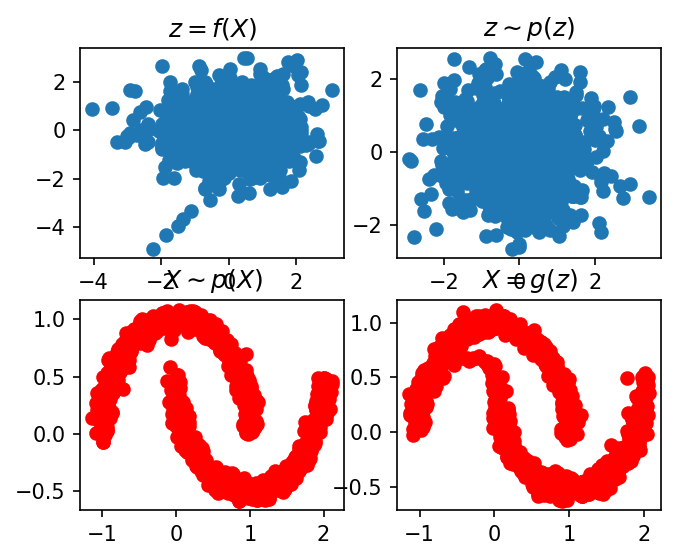

In [ ]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = prior.sample((1000,))
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X = g(z)$')

In [ ]:
xpoints = np.linspace(-1.5, 2.5, 500)
ypoints = np.linspace(-1.0, 1.5, 500)
(x1, x2,) = np.meshgrid(xpoints, ypoints)
xgrid = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis=1).astype(np.float32)
p = np.exp(flow.log_prob(torch.from_numpy(xgrid)).detach().numpy())

In [ ]:
fig = plt.figure()
plt.imshow(
    p.reshape(x1.shape), aspect="equal", origin="lower")
plt.axis('off')
plt.show()

## Clustering Normalized Flow

In [ ]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]).astype(np.float32))

In [ ]:
mix = distributions.Categorical(torch.ones(2))
gau = distributions.MultivariateNormal(torch.eye(2), 0.05*torch.eye(2))
prior = distributions.mixture_same_family.MixtureSameFamily(mix, gau) # distributions.MultivariateNormal(torch.tensor([0.,1.]), torch.eye(2))

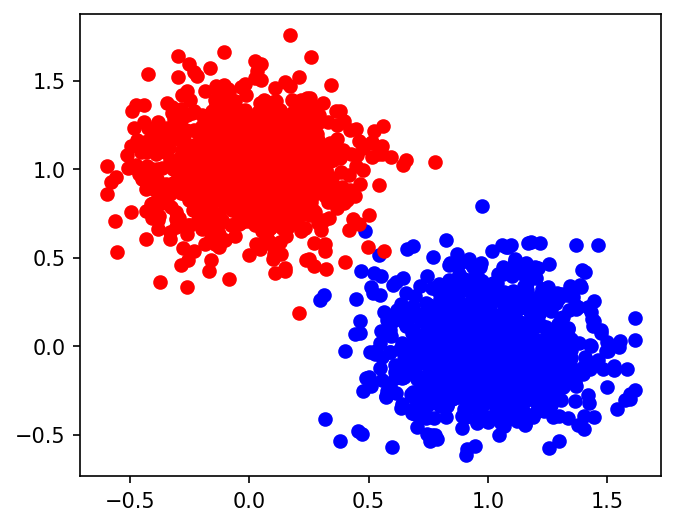

In [ ]:
z = prior.component_distribution.sample((1000,))
plt.scatter(z[:,0, 0], z[:,0, 1], c='b')
plt.scatter(z[:,1, 0], z[:,1, 1], c='r')

In [ ]:
print(prior.log_prob(torch.Tensor([0,0])))
print(prior.sample((3,)))

tensor(-8.8421)
tensor([[ 0.7016, -0.1390],
        [-0.1297,  1.0512],
        [ 1.0231, -0.0141]])


In [ ]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        # create a flow
        # nets:  a function that returns a PyTorch neural network, e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that returns a PyTorch neural network, e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        self.prior = prior
        self.mask = mask
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])

    def f(self, x):
        # compute f(x) = z and log_det_Jacobian of f, where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in range(len(self.t)):
            z_ = z*self.mask[i]
            s = self.s[i](z_)*(1-self.mask[i])
            t = self.t[i](z_)*(1-self.mask[i])
            z = z * torch.exp(s) + t
            log_det_J += s.sum(dim=1)

        return z, log_det_J

    def log_prob(self, x):
        # compute and return log p(x) using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, logdet = self.f(x)
        return self.prior.log_prob(z) + logdet

    def g(self, z):
        # compute and return g(z) = x, where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer
        # z: a torch.Tensor of shape batchSize x dim(X)
        # return x: a torch.Tensor of shape batchSize x dim(X)
        x = z
        for i in reversed(range(len(self.t))):
            x_ = self.mask[i] * x
            s = self.s[i](x_) * (1-self.mask[i])
            t = self.t[i](x_) * (1-self.mask[i])
            x = (x-t) * torch.exp(-s)
        return x

    def sample(self, batchSize):
        # draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x dim(X)
        z = self.prior.sample((batchSize,))
        x = self.g(z)
        return x

    def sample_cond(self,batchSize):
        # this is the new piece allowing to sample from each component of the mixture
        comp = self.prior.component_distribution
        z = comp.sample((batchSize,))
        z0 = z[:,0,:]
        z1 = z[:,1,:]
        x0 = self.g(z0)
        x1 = self.g(z1)
        return x0,x1,z0,z1

In [ ]:
flow = RealNVP(nets, nett, masks, prior)

In [ ]:
x = torch.randn((10,2))
y, _ = flow.f(flow.g(x))
torch.allclose(x, y)

True

In [ ]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
for t in range(1001):
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 8.325
iter 500: loss = 0.656
iter 1000: loss = 0.476


Text(0.5, 1.0, '$X = g(z)$')

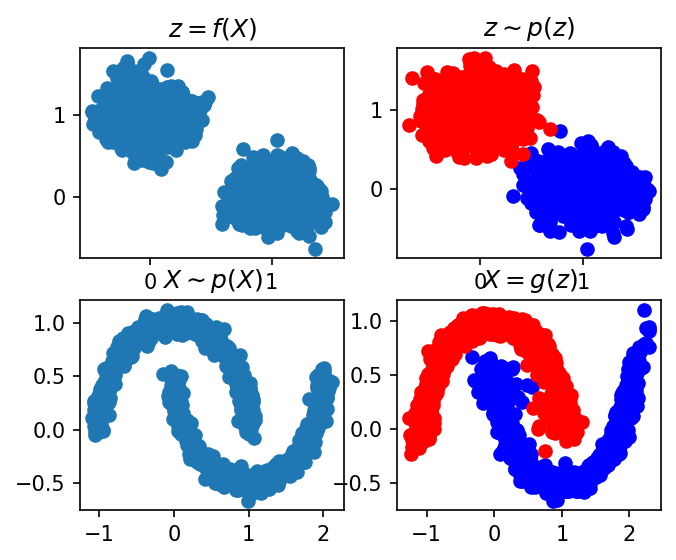

In [ ]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

x0,x1,z0,z1 = flow.sample_cond(1000)
x0 = x0.detach().numpy()
x1 = x1.detach().numpy()
z0 = z0.detach().numpy()
z1 = z1.detach().numpy()

plt.subplot(222)
plt.scatter(z0[:, 0], z0[:, 1], c='b')
plt.scatter(z1[:, 0], z1[:, 1], c='r')
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = noisy_moons # datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1])
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
# x = flow.sample(1000).detach().numpy()
plt.scatter(x0[:, 0], x0[:, 1], c='b')
plt.scatter(x1[:, 0], x1[:, 1], c='r')
plt.title(r'$X = g(z)$')

## AutoEncoder

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/DataSets/"
root_dir = os.path.join(ROOT_DIR,'data/PytorchMNIST/')
train_loader = torch.utils.data.DataLoader(
    dset.MNIST(root_dir, train=True, download=True, transform=T.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dset.MNIST(root_dir, train=False, download=True, transform=T.ToTensor()),
    batch_size=10, shuffle=False)

In [ ]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
input_dim = 784
encoding_dim = 64
model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [ ]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
train_model(model, loss_fn, data_loader=train_loader, epochs=2, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.128065
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.047489
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.034361
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.030626
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.025965
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.023178


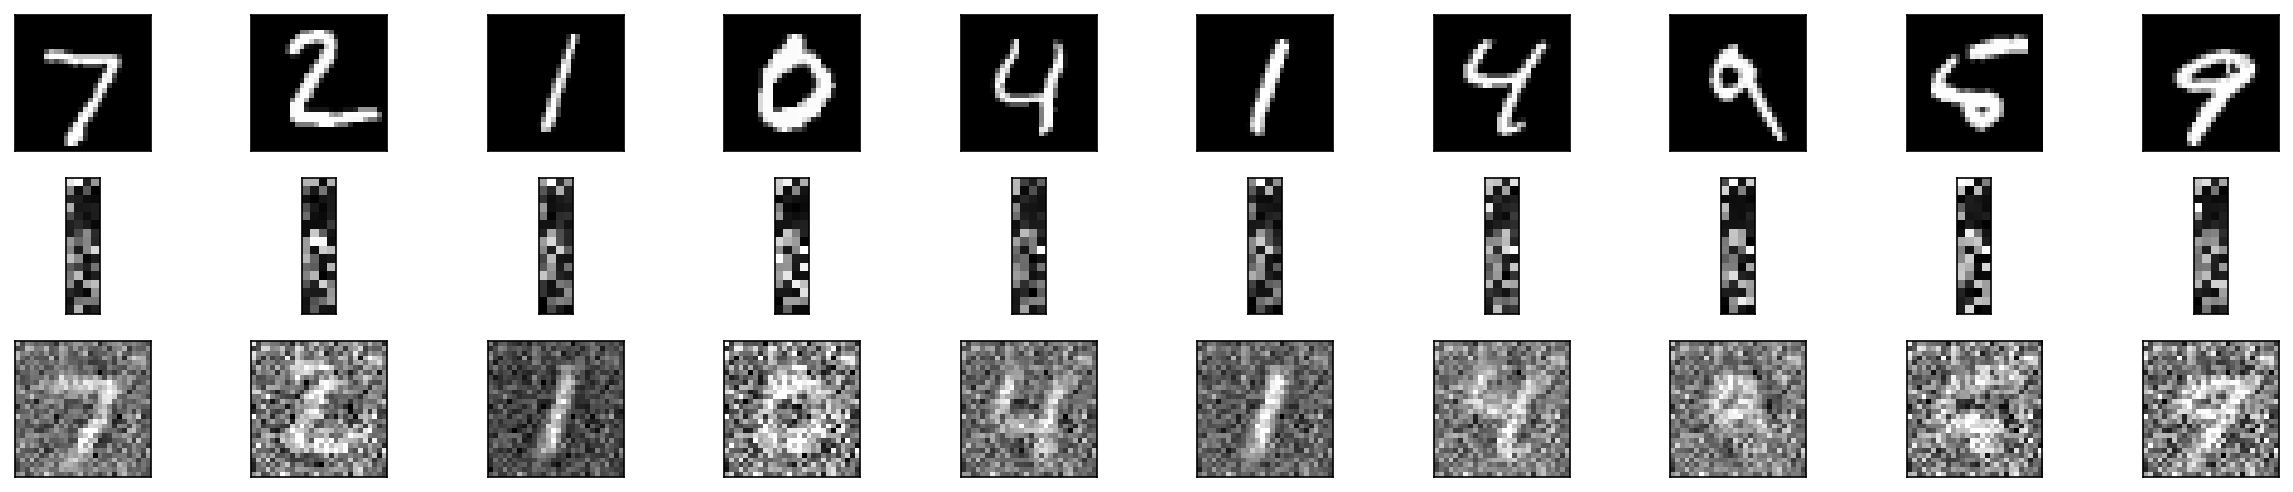

In [ ]:
plot_reconstructions(model)

In [ ]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),

        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
input_dim = 784
encoding_dim = 32
model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [ ]:
train_model(model, loss_fn, data_loader=train_loader, epochs=2, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.118787
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.043588
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.030953
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.031206
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.026133
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.023936


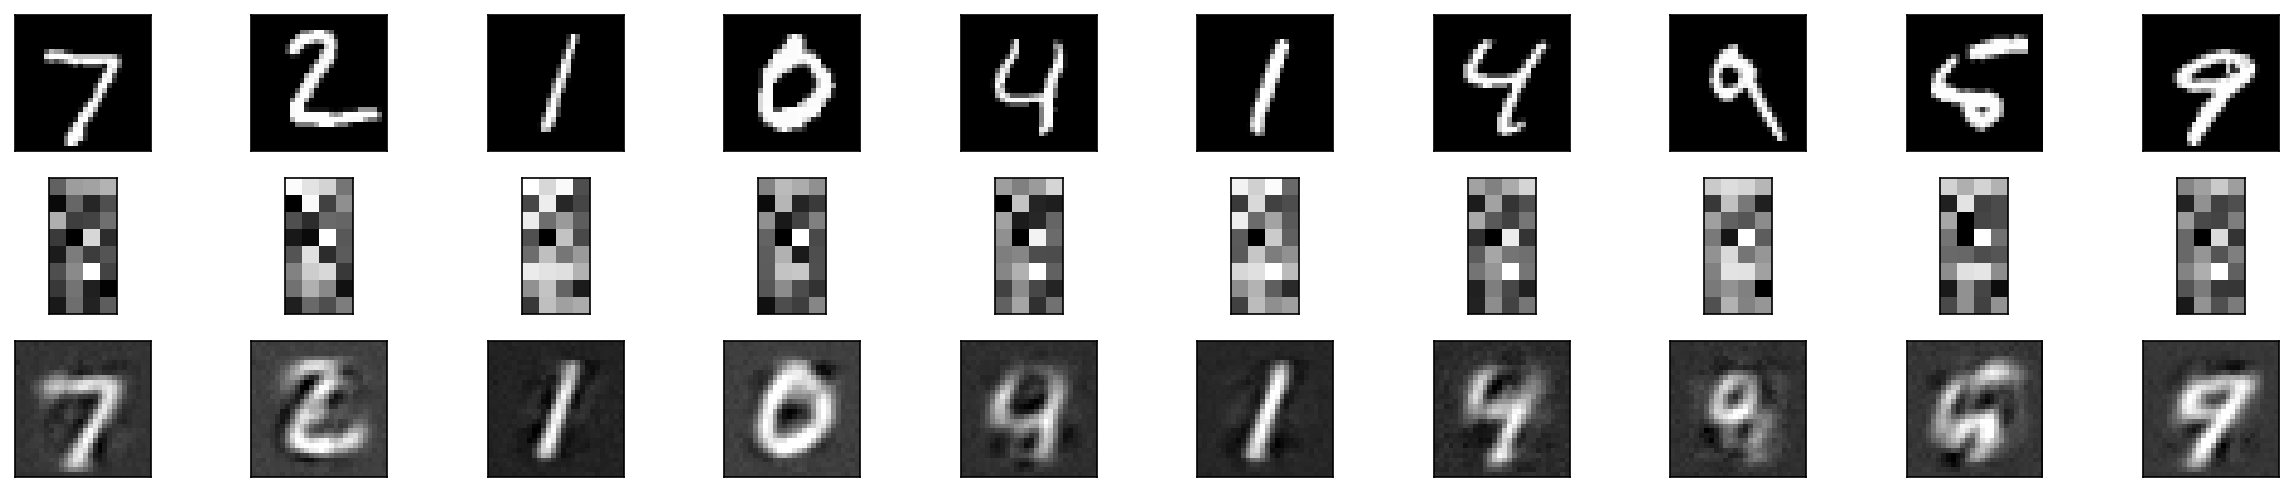

In [ ]:
plot_reconstructions(model)

In [ ]:
model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn =torch.nn.BCEWithLogitsLoss()
train_model(model, loss_fn, data_loader=train_loader, epochs=2, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.693304
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.260506
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.228480
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.226914
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.193759
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.177658


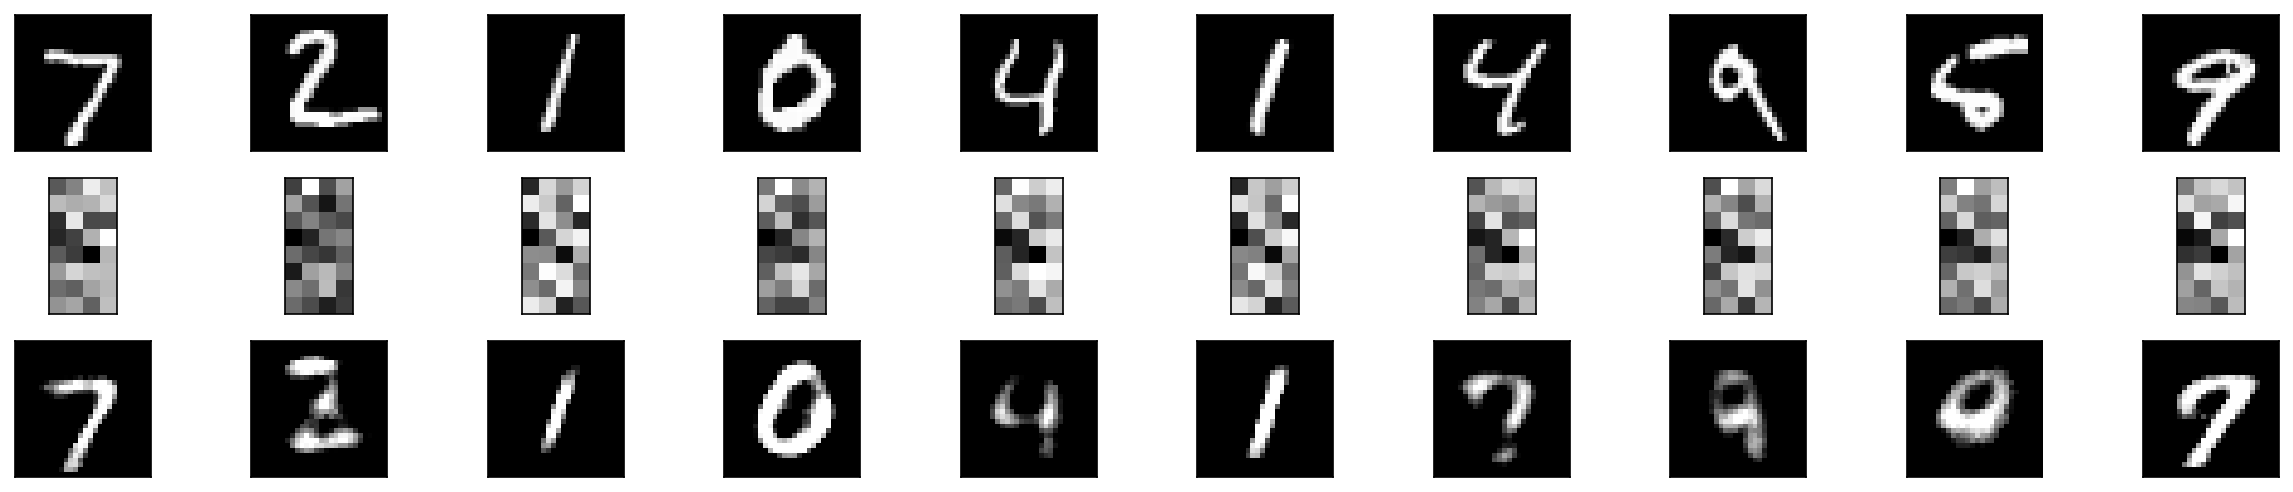

In [ ]:
plot_reconstructions(model)

In [ ]:
data, labels = next(iter(test_loader))
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [ ]:
encoded_0 = model.encoder(data[1].view(-1,784).to(device))
encoded_1 = model.encoder(data[9].view(-1,784).to(device))

In [ ]:
alpha = torch.linspace(0,1,steps=10)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha) * encoded_0 + alpha * encoded_1

In [ ]:
decoded_imgs = model.decoder(interp)

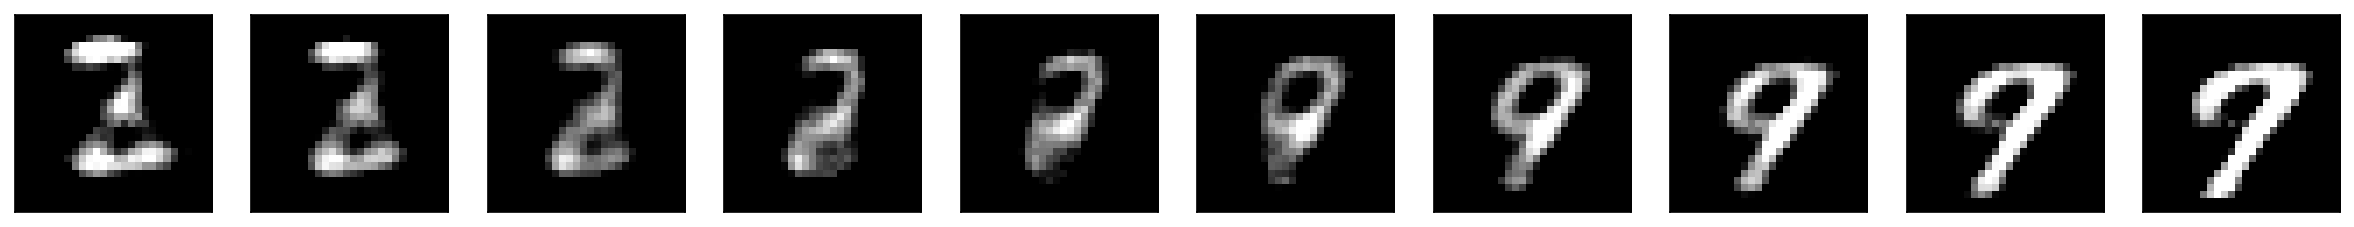

In [ ]:
decoded_imgs = to_img(decoded_imgs)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
n = 100
alpha = torch.linspace(0,1,steps=n)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1
decoded_imgs = model.decoder(interp)
decoded_imgs = to_img(decoded_imgs)

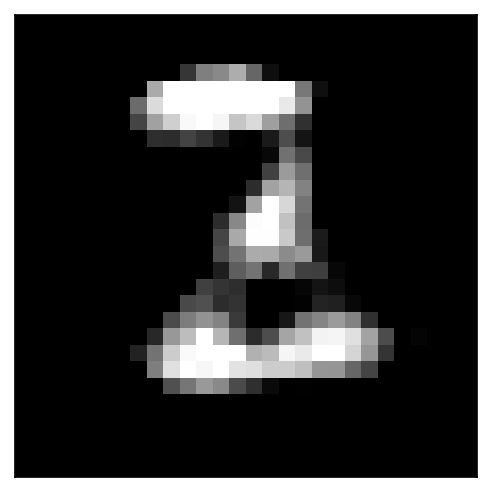

In [ ]:
fig, ax = plt.subplots()
ims = []
for i in range(len(decoded_imgs)):
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    im = ax.imshow(decoded_imgs[i], animated=True)
    if i == 0:
        ax.imshow(decoded_imgs[0])
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()

In [ ]:
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            # mask = torch.empty_like(data).uniform_() > noise
            # noisy_data = data * mask
            mask = torch.zeros_like(data)
            level = 10
            mask[:,:,-level:,:] = torch.ones(mask.shape[0],1,level,28)
            noisy_data = mask * data

            data = data.view([-1, 784]).to(device)
            noisy_data = noisy_data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
input_dim = 784
encoding_dim = 32
model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_denoiser(model, loss_fn,data_loader=train_loader, epochs=2, optimizer=optimizer, noise=0.8)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.692307
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.267282
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.243979
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.238592
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.209066
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.200389


In [ ]:
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits,
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    # mask = torch.empty_like(data).uniform_() > noise
    # noisy_data = mask * data
    mask = torch.zeros_like(data)
    level = 10
    mask[:,:,-level:,:] = torch.ones(10,1,level,28)
    noisy_data = mask * data
    data = data.to(device)
    noisy_data = noisy_data.to(device)
    noisy_data.requires_grad = False
    data = data.view([-1, 784])
    noisy_data = noisy_data.view([-1,784])
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)
    #
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    #
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

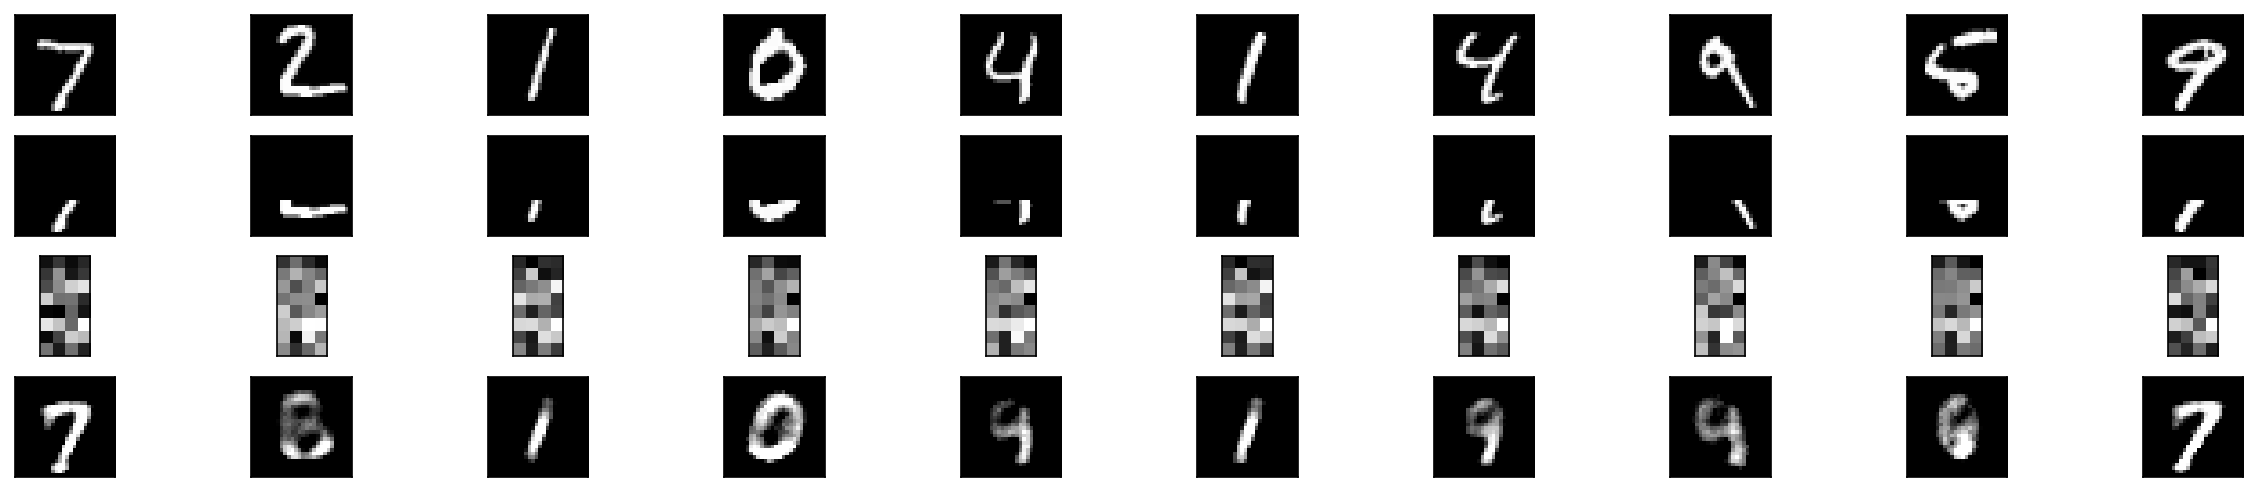

In [ ]:
plot_denoising(model, noise=0.8)

In [ ]:
conv = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2)
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 16, 32, 32])

In [ ]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, stride=2)

In [ ]:
convt(y).shape

torch.Size([2, 8, 63, 63])

In [ ]:
class Conv_AutoEncoder(nn.Module):
    def __init__(self):
        super(Conv_AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train_model_conv(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
model = Conv_AutoEncoder()
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
data, _ = next(iter(test_loader))
data = data.to(device)

In [ ]:
model(data).shape

torch.Size([10, 1, 28, 28])

In [ ]:
train_model_conv(model, loss_fn, data_loader=train_loader, epochs=2, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.791522
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.161542
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.095632
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.087464
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.078258
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.075227


In [ ]:
class Conv_Up(nn.Module):
    def __init__(self):
        super(Conv_Up, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 3, stride=3, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=3, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Conv_Up()
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
def train_model_up(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(F.avg_pool2d(data, kernel_size = 2))
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
train_model_up(model, loss_fn, data_loader=train_loader, epochs=2, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.793786
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.300434
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.220363
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.183871
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.134111
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.117644


In [ ]:
def to_img(x, size=28):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, size, size])
    return x

def plot_up_conv(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    noisy_data = F.avg_pool2d(data, kernel_size = 2)
    # data += noise * torch.randn(data.size())
    data = data.to(device)
    noisy_data = noisy_data.to(device)

    # data = data.view([-1, 784])
    # noisy_data = noisy_data.view([-1,784])
    noisy_data.requires_grad = False
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data, size=14)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

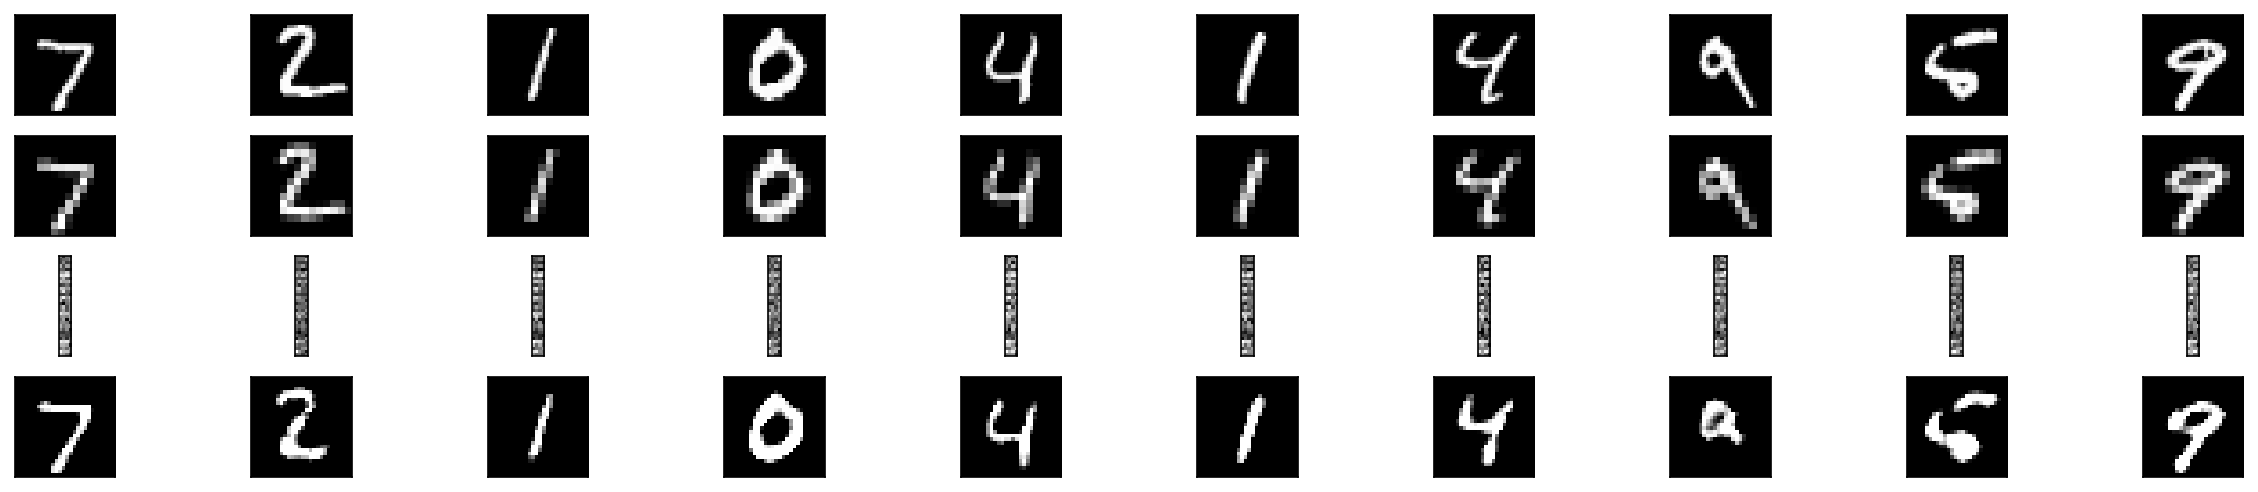

In [ ]:
plot_up_conv(model)

## GANs

### Vanilla

In [ ]:
def plot_data(ax, X, Y, color = 'bone'):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap=color)

In [ ]:
X, y = datasets.make_moons(n_samples=2000, noise=0.05)

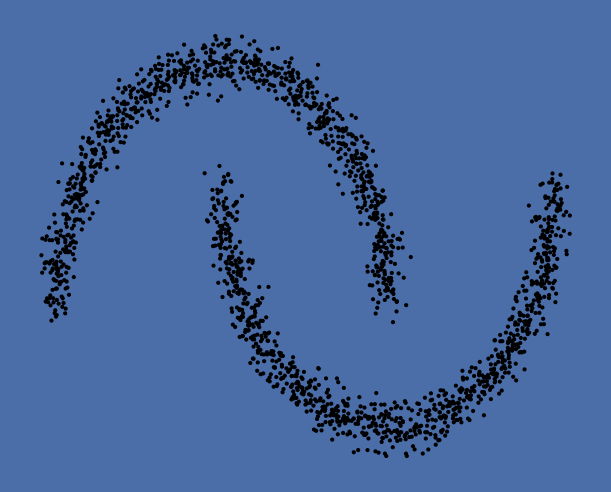

In [ ]:
n_samples = X.shape[0]
Y = np.ones(n_samples)
fig, ax = plt.subplots(1, 1,facecolor='#4B6EA9')
plot_data(ax, X, Y)
plt.show()

In [ ]:
device

device(type='cpu')

In [ ]:
z_dim = 32
hidden_dim = 128
net_G = nn.Sequential(nn.Linear(z_dim, hidden_dim),
                     nn.ReLU(), nn.Linear(hidden_dim, 2))

net_D = nn.Sequential(nn.Linear(2, hidden_dim),
                     nn.ReLU(),
                     nn.Linear(hidden_dim, 1),
                     nn.Sigmoid())
net_G = net_G.to(device)
net_D = net_D.to(device)

In [ ]:
batch_size = 50
lr = 1e-4
nb_epochs = 500
optimizer_G = torch.optim.Adam(net_G.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(net_D.parameters(), lr=lr)
loss_D_epoch = []
loss_G_epoch = []
for e in range(nb_epochs):
    np.random.shuffle(X)
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    loss_G = 0
    loss_D = 0
    for t, real_batch in enumerate(real_samples.split(batch_size)):
        #improving D
        z = torch.empty(batch_size, z_dim).normal_().to(device)
        fake_batch = net_G(z)
        D_scores_on_real = net_D(real_batch.to(device))
        D_scores_on_fake = net_D(fake_batch)
        loss = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        optimizer_D.zero_grad()
        loss.backward()
        optimizer_D.step()
        loss_D += loss.cpu().data.numpy()
        # improving G
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        D_scores_on_fake = net_D(fake_batch)
        loss = -torch.mean(torch.log(D_scores_on_fake))
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()
        loss_G += loss.cpu().data.numpy()
    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)

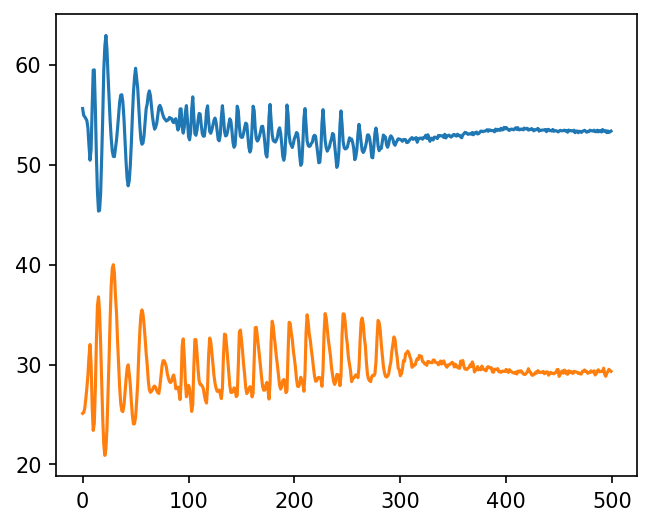

In [ ]:
plt.plot(loss_D_epoch)
plt.plot(loss_G_epoch)

In [ ]:
z = torch.empty(n_samples,z_dim).normal_().to(device)
fake_samples = net_G(z)
fake_data = fake_samples.cpu().data.numpy()

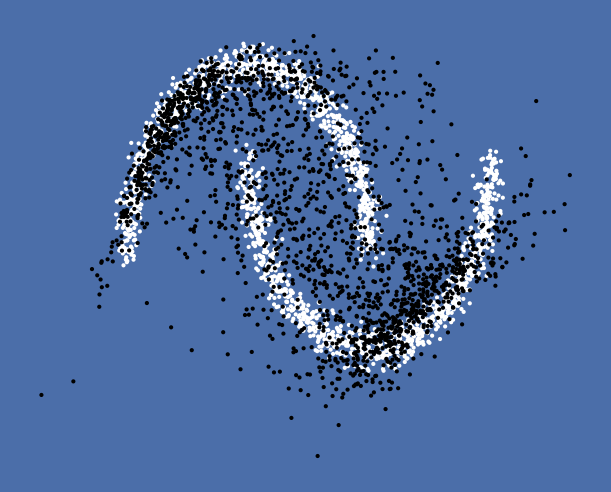

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
all_data = np.concatenate((X,fake_data), axis=0)
Y2 = np.concatenate((np.ones(n_samples), np.zeros(n_samples)))
plot_data(ax, all_data, Y2)
plt.show()

In [ ]:
batch_size = 50
lr = 1e-3
nb_epochs = 500
optimizer_G = torch.optim.Adam(net_G.parameters(),lr=lr)
optimizer_D = torch.optim.Adam(net_D.parameters(),lr=lr)
loss_D_epoch = []
loss_G_epoch = []
for e in range(nb_epochs):
    np.random.shuffle(X)
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    loss_G = 0
    loss_D = 0
    for t, real_batch in enumerate(real_samples.split(batch_size)):
        # improving D
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        D_scores_on_real = net_D(real_batch.to(device))
        D_scores_on_fake = net_D(fake_batch)
        loss = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        optimizer_D.zero_grad()
        loss.backward()
        optimizer_D.step()
        loss_D += loss.cpu().data.numpy()
        # improving G
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        D_scores_on_fake = net_D(fake_batch)
        loss = -torch.mean(torch.log(D_scores_on_fake))
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()
        loss_G += loss.cpu().data.numpy()
    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)

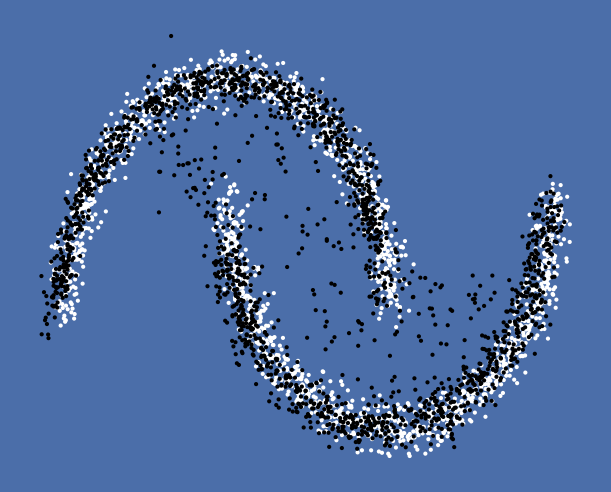

In [ ]:
z = torch.empty(n_samples,z_dim).normal_().to(device)
fake_samples = net_G(z)
fake_data = fake_samples.cpu().data.numpy()
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
all_data = np.concatenate((X,fake_data),axis=0)
Y2 = np.concatenate((np.ones(n_samples),np.zeros(n_samples)))
plot_data(ax, all_data, Y2)
plt.show();

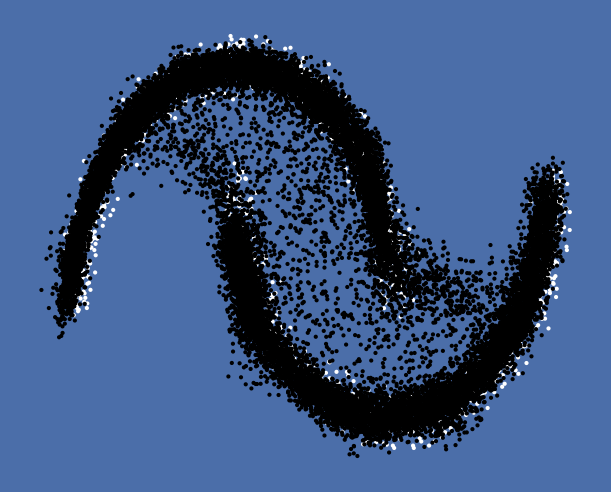

In [ ]:
z = torch.empty(10*n_samples,z_dim).normal_().to(device)
fake_samples = net_G(z)
fake_data = fake_samples.cpu().data.numpy()
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
all_data = np.concatenate((X, fake_data),axis=0)
Y2 = np.concatenate((np.ones(n_samples),np.zeros(10*n_samples)))
plot_data(ax, all_data, Y2)
plt.show()

### Canditional

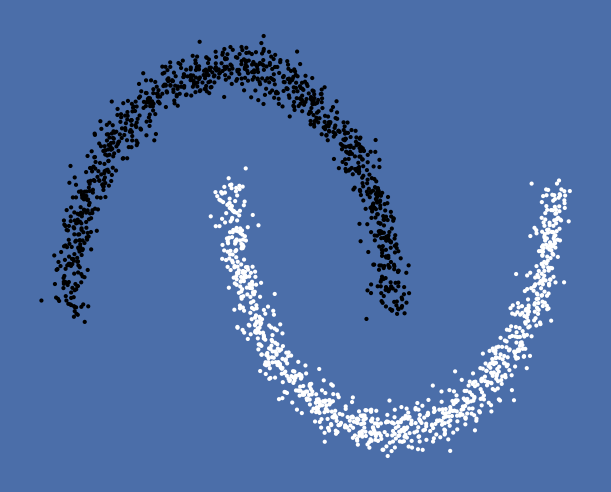

In [ ]:
X, Y = datasets.make_moons(n_samples=2000, noise=0.05)
n_samples = X.shape[0]
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_data(ax, X, Y)
plt.show()

In [ ]:
z_dim = 32
hidden_dim = 128
label_dim = 2

class generator(nn.Module):
    def __init__(self, z_dim = z_dim, label_dim=label_dim, hidden_dim=hidden_dim):
        super(generator,self).__init__()
        self.net = nn.Sequential(nn.Linear(z_dim+label_dim, hidden_dim),
                     nn.ReLU(), nn.Linear(hidden_dim, 2))

    def forward(self, input, label_onehot):
        x = torch.cat([input, label_onehot], 1)
        return self.net(x)

class discriminator(nn.Module):
    def __init__(self, z_dim = z_dim, label_dim=label_dim, hidden_dim=hidden_dim):
        super(discriminator,self).__init__()
        self.net =  nn.Sequential(nn.Linear(2+label_dim, hidden_dim),
                     nn.ReLU(),
                     nn.Linear(hidden_dim, 1),
                     nn.Sigmoid())

    def forward(self, input, label_onehot):
        x = torch.cat([input, label_onehot], 1)
        return self.net(x)

net_CG = generator().to(device)
net_CD = discriminator().to(device)

In [ ]:
batch_size = 50
lr = 1e-3
nb_epochs = 1000

optimizer_CG = torch.optim.Adam(net_CG.parameters(), lr=lr)
optimizer_CD = torch.optim.Adam(net_CD.parameters(), lr=lr)
loss_D_epoch = []
loss_G_epoch = []
for e in range(nb_epochs):
    rperm = np.random.permutation(X.shape[0]);
    np.take(X, rperm, axis=0, out=X);
    np.take(Y, rperm, axis=0, out=Y);
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    real_labels = torch.from_numpy(Y).type(torch.LongTensor)
    loss_G = 0
    loss_D = 0
    for real_batch, real_batch_label in zip(real_samples.split(batch_size), real_labels.split(batch_size)):
        # improving D
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        label = torch.LongTensor(batch_size,1).random_() % label_dim
        label_onehot = torch.FloatTensor(batch_size, label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, label, 1).to(device)
        fake_batch = net_CG(z, label_onehot)
        D_scores_on_fake = net_CD(fake_batch, label_onehot)
        label_onehot = torch.FloatTensor(batch_size, label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, real_batch_label.unsqueeze(1), 1).to(device)
        D_scores_on_real = net_CD(real_batch.to(device),label_onehot)
        loss = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        optimizer_CD.zero_grad()
        loss.backward()
        optimizer_CD.step()
        loss_D += loss.cpu().data.numpy()
        # improving G
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        label = torch.LongTensor(batch_size,1).random_() % label_dim
        label_onehot = torch.FloatTensor(batch_size, label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, label, 1).to(device)
        fake_batch = net_CG(z, label_onehot)
        D_scores_on_fake = net_CD(fake_batch, label_onehot)
        loss = -torch.mean(torch.log(D_scores_on_fake))
        optimizer_CG.zero_grad()
        loss.backward()
        optimizer_CG.step()
        loss_G += loss.cpu().data.numpy()

    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)

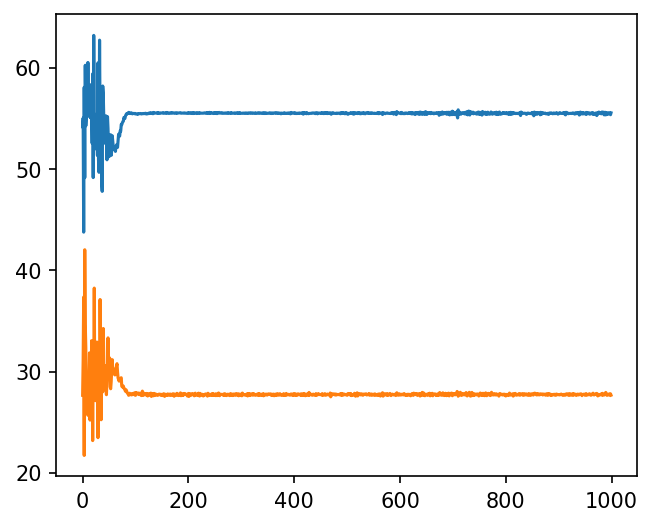

In [ ]:
plt.plot(loss_D_epoch)
plt.plot(loss_G_epoch)

In [ ]:
z = torch.empty(n_samples,z_dim).normal_().to(device)
label = torch.LongTensor(n_samples,1).random_() % label_dim
label_onehot = torch.FloatTensor(n_samples, label_dim).zero_()
label_onehot = label_onehot.scatter_(1, label, 1).to(device)
fake_samples = net_CG(z, label_onehot)
fake_data = fake_samples.cpu().data.numpy()

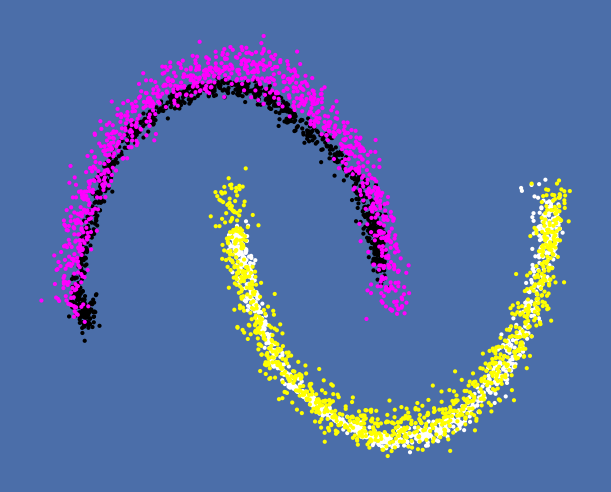

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_data(ax, fake_data, label.squeeze().numpy())
plot_data(ax, X, Y, 'spring')
plt.show()

### InfoGAN

In [ ]:
z_dim = 32
hidden_dim = 128
label_dim = 2

class Igenerator(nn.Module):
    def __init__(self,z_dim = z_dim, label_dim=label_dim,hidden_dim =hidden_dim):
        super(Igenerator,self).__init__()
        self.net = nn.Sequential(nn.Linear(z_dim+label_dim,hidden_dim),
                     nn.ReLU(), nn.Linear(hidden_dim, 2))

    def forward(self, input, label_onehot):
        x = torch.cat([input, label_onehot], 1)
        return self.net(x)

class Idiscriminator(nn.Module):
    def __init__(self,z_dim = z_dim, label_dim=label_dim,hidden_dim =hidden_dim):
        super(Idiscriminator,self).__init__()
        self.fc1 = nn.Linear(2,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,1)
        self.fc3 = nn.Linear(hidden_dim,1)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        output = torch.sigmoid(self.fc2(x))
        est_label = torch.sigmoid(self.fc3(x))
        return output, est_label

net_IG = Igenerator().to(device)
net_ID = Idiscriminator().to(device)

In [ ]:
batch_size = 50
lr = 1e-3
nb_epochs = 1000
loss_fn = nn.BCELoss()

In [ ]:
optimizer_IG = torch.optim.Adam(net_IG.parameters(),lr=lr)
optimizer_ID = torch.optim.Adam(net_ID.parameters(),lr=lr)
loss_D_epoch = []
loss_G_epoch = []
for e in range(nb_epochs):

    rperm = np.random.permutation(X.shape[0]);
    np.take(X,rperm,axis=0,out=X);
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    loss_G = 0
    loss_D = 0
    for real_batch in real_samples.split(batch_size):
        #improving D
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        label = torch.LongTensor(batch_size,1).random_() % label_dim
        label_onehot = torch.FloatTensor(batch_size, label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, label, 1).to(device)
        fake_batch = net_IG(z, label_onehot)
        D_scores_on_fake, est_label_on_fake = net_ID(fake_batch)
        D_scores_on_real, est_label_on_real = net_ID(real_batch.to(device))
        lossD = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        lossD.add_(loss_fn(est_label_on_fake,label.type(torch.FloatTensor).to(device)))
        optimizer_ID.zero_grad()
        lossD.backward()
        optimizer_ID.step()
        loss_D += lossD.cpu().data.numpy()
        # improving G
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        label = torch.LongTensor(batch_size,1).random_() % label_dim
        label_onehot = torch.FloatTensor(batch_size, label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, label, 1).to(device)
        fake_batch = net_IG(z, label_onehot)
        D_scores_on_fake, est_label_on_fake = net_ID(fake_batch)
        lossG = -torch.mean(torch.log(D_scores_on_fake))
        lossG.add_(loss_fn(est_label_on_fake,label.type(torch.FloatTensor).to(device)))
        optimizer_IG.zero_grad()
        lossG.backward()
        optimizer_IG.step()
        loss_G += lossG.cpu().data.numpy()

    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)

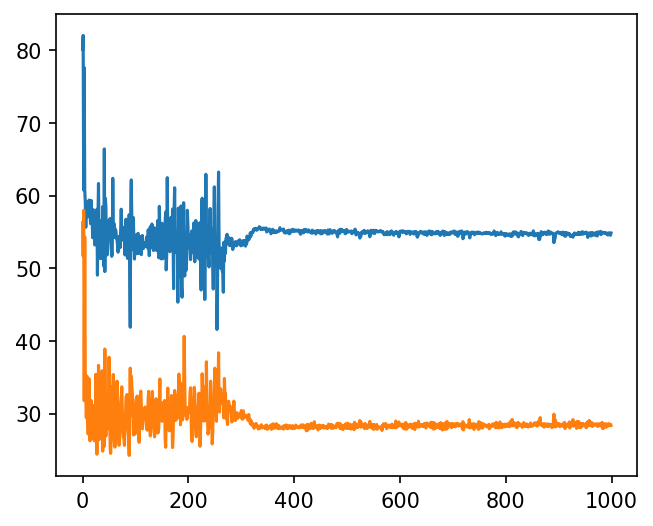

In [ ]:
plt.plot(loss_D_epoch)
plt.plot(loss_G_epoch)

In [ ]:
z = torch.empty(n_samples,z_dim).normal_().to(device)
label = torch.LongTensor(n_samples,1).random_() % label_dim
label_onehot = torch.FloatTensor(n_samples, label_dim).zero_()
label_onehot = label_onehot.scatter_(1, label, 1).to(device)
fake_samples = net_IG(z, label_onehot)
fake_data = fake_samples.cpu().data.numpy()

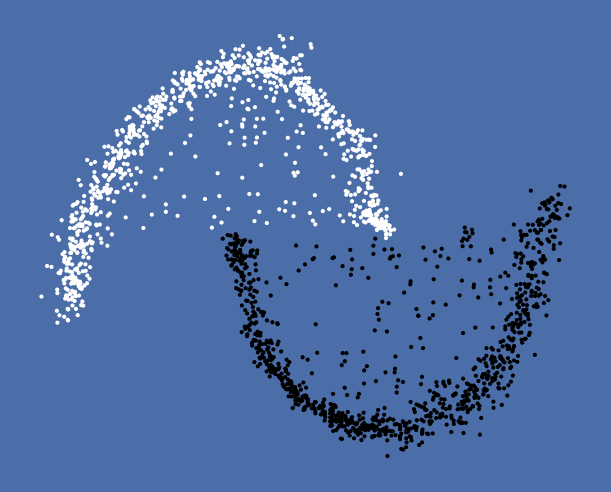

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_data(ax, fake_data, label.squeeze().numpy())
plt.show()